## On-policy vs. Off-policy


## Q-learning ϵ-greedy

In [ ]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import softmax
from keras.optimizers import Adam
import os
import time
import numpy as np

In [ ]:
def softmax(x, temperature=0.025):
    """Compute softmax values for each sets of scores in x."""
    x = (x - np.expand_dims(np.max(x, 1), 1))
    x = x/temperature
    e_x = np.exp(x)
    return e_x / (np.expand_dims(e_x.sum(1), -1) + 1e-5)

## DQNAgent
class DQNAgent:
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=20000)
    self.gamma = 0.95       # discount rate
    self.epsilon = 1.0      # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.learning_rate = 0.001
    self.model = self._build_model()


  def _build_model(self):
    # Neural Net for Deep-Q learning Model
    model = Sequential()
    model.add(Dense(24, input_dim=self.state_size, activation='relu'))
    model.add(Dense(48, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss='mse',
                  optimizer=Adam(lr=self.learning_rate))
    return model

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  def act(self, state):
    ## We implement the epsilon-greedy policy
    if np.random.rand() <= self.epsilon:
        return random.randrange(self.action_size)
    act_values = self.model.predict(state, verbose=0)
    return np.argmax(act_values[0]) # returns action

  def exploit(self, state):
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])

  def replay(self, batch_size):
    minibatch = random.sample(self.memory, batch_size)

    state_b = np.squeeze(np.array(list(map(lambda x: x[0], minibatch))))
    action_b = np.squeeze(np.array(list(map(lambda x: x[1], minibatch))))
    reward_b = np.squeeze(np.array(list(map(lambda x: x[2], minibatch))))
    next_state_b = np.squeeze(np.array(list(map(lambda x: x[3], minibatch))))
    done_b = np.squeeze(np.array(list(map(lambda x: x[4], minibatch))))

    ### Q-learning
    target = (reward_b + self.gamma * np.amax(self.model.predict(next_state_b, verbose=0), 1))
    target[done_b==1] = reward_b[done_b==1]
    target_f = self.model.predict(state_b, verbose=0)

    for k in range(target_f.shape[0]):
      target_f[k][action_b[k]] = target[k]
    self.model.fit(state_b, target_f, batch_size=state_b.shape[0], verbose=0)
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

  def load(self, name):
    self.model.load_weights(name)
  def save(self, name):
    self.model.save_weights(name)

In [ ]:
  EPISODES = 200
  env = gym.make('CartPole-v0')
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n
  agent = DQNAgent(state_size, action_size)   ## AGENT
  batch_size = 32
  episode_reward_list = deque(maxlen=50)
  q_egreedy_reward_avg50_list = []
  for e in range(EPISODES):
      state = env.reset()
      state = np.reshape(state, [1, state_size])
      total_reward = 0
      for time in range(200):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
      episode_reward_list.append(total_reward)
      episode_reward_avg = np.array(episode_reward_list).mean()
      q_egreedy_reward_avg50_list.append(episode_reward_avg)
      print("episode: {}/{}, score: {}, e: {:.2}, last 50 ep. avg. rew.: {:.2f}"
                  .format(e, EPISODES, total_reward, agent.epsilon, episode_reward_avg))

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


episode: 0/200, score: 12.0, e: 1.0, last 50 ep. avg. rew.: 12.00
episode: 1/200, score: 14.0, e: 1.0, last 50 ep. avg. rew.: 13.00
episode: 2/200, score: 30.0, e: 0.89, last 50 ep. avg. rew.: 18.67
episode: 3/200, score: 25.0, e: 0.79, last 50 ep. avg. rew.: 20.25
episode: 4/200, score: 17.0, e: 0.73, last 50 ep. avg. rew.: 19.60
episode: 5/200, score: 9.0, e: 0.7, last 50 ep. avg. rew.: 17.83
episode: 6/200, score: 11.0, e: 0.67, last 50 ep. avg. rew.: 16.86
episode: 7/200, score: 10.0, e: 0.64, last 50 ep. avg. rew.: 16.00
episode: 8/200, score: 14.0, e: 0.6, last 50 ep. avg. rew.: 15.78
episode: 9/200, score: 22.0, e: 0.54, last 50 ep. avg. rew.: 16.40
episode: 10/200, score: 10.0, e: 0.51, last 50 ep. avg. rew.: 15.82
episode: 11/200, score: 12.0, e: 0.49, last 50 ep. avg. rew.: 15.50
episode: 12/200, score: 12.0, e: 0.46, last 50 ep. avg. rew.: 15.23
episode: 13/200, score: 33.0, e: 0.39, last 50 ep. avg. rew.: 16.50
episode: 14/200, score: 13.0, e: 0.37, last 50 ep. avg. rew.: 1

## Q-learning softmax

In [ ]:
def softmax(x, temperature=0.025):
    """Compute softmax values for each sets of scores in x."""
    x = (x - np.expand_dims(np.max(x, 1), 1))
    x = x/temperature
    e_x = np.exp(x)
    return e_x / (np.expand_dims(e_x.sum(1), -1) + 1e-5)

## DQNAgent
class DQNAgent:
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=20000)
    self.gamma = 0.95       # discount rate
    self.epsilon = 1.0      # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.learning_rate = 0.001
    self.model = self._build_model()


  def _build_model(self):
    # Neural Net for Deep-Q learning Model
    model = Sequential()
    model.add(Dense(24, input_dim=self.state_size, activation='relu'))
    model.add(Dense(48, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss='mse',
                  optimizer=Adam(lr=self.learning_rate))
    return model

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  def act(self, state):
    ## Softmax policy
    act_values = self.model.predict(state, verbose=0)
    p = softmax(act_values)[0]
    p = p / p.sum()
    return np.random.choice(np.arange(self.action_size), p=p) # returns action

  def exploit(self, state):
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])

  ## MODIFY REPLAY
  def replay(self, batch_size):
    minibatch = random.sample(self.memory, batch_size)

    state_b = np.squeeze(np.array(list(map(lambda x: x[0], minibatch))))
    action_b = np.squeeze(np.array(list(map(lambda x: x[1], minibatch))))
    reward_b = np.squeeze(np.array(list(map(lambda x: x[2], minibatch))))
    next_state_b = np.squeeze(np.array(list(map(lambda x: x[3], minibatch))))
    done_b = np.squeeze(np.array(list(map(lambda x: x[4], minibatch))))

    ### Q-learning
    target = (reward_b + self.gamma * np.amax(self.model.predict(next_state_b, verbose=0), 1))
    target[done_b==1] = reward_b[done_b==1]
    target_f = self.model.predict(state_b, verbose=0)

    for k in range(target_f.shape[0]):
      target_f[k][action_b[k]] = target[k]
    self.model.fit(state_b, target_f, batch_size=state_b.shape[0], verbose=0)
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

  def load(self, name):
    self.model.load_weights(name)
  def save(self, name):
    self.model.save_weights(name)

In [ ]:
  EPISODES = 200
  env = gym.make('CartPole-v0')
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n
  agent = DQNAgent(state_size, action_size)   ## AGENT
  batch_size = 32
  episode_reward_list = deque(maxlen=50)
  q_softmax_reward_avg50_list = []
  for e in range(EPISODES):
      state = env.reset()
      state = np.reshape(state, [1, state_size])
      total_reward = 0
      for time in range(200):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
      episode_reward_list.append(total_reward)
      episode_reward_avg = np.array(episode_reward_list).mean()
      q_softmax_reward_avg50_list.append(episode_reward_avg)
      print("episode: {}/{}, score: {}, e: {:.2}, last 50 ep. avg. rew.: {:.2f}"
                  .format(e, EPISODES, total_reward, agent.epsilon, episode_reward_avg))

episode: 0/200, score: 9.0, e: 1.0, last 50 ep. avg. rew.: 9.00
episode: 1/200, score: 10.0, e: 1.0, last 50 ep. avg. rew.: 9.50
episode: 2/200, score: 10.0, e: 1.0, last 50 ep. avg. rew.: 9.67
episode: 3/200, score: 11.0, e: 0.97, last 50 ep. avg. rew.: 10.00


KeyboardInterrupt: ignored

## SARSA ϵ-greedy

In [ ]:
def softmax(x, temperature=0.025):
    """Compute softmax values for each sets of scores in x."""
    x = (x - np.expand_dims(np.max(x, 1), 1))
    x = x/temperature
    e_x = np.exp(x)
    return e_x / (np.expand_dims(e_x.sum(1), -1) + 1e-5)

## DQNAgent
class DQNAgent:
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=20000)
    self.gamma = 0.95       # discount rate
    self.epsilon = 1.0      # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.learning_rate = 0.001
    self.model = self._build_model()


  def _build_model(self):
    # Neural Net for Deep-Q learning Model
    model = Sequential()
    model.add(Dense(24, input_dim=self.state_size, activation='relu'))
    model.add(Dense(48, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss='mse',
                  optimizer=Adam(lr=self.learning_rate))
    return model

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  def act(self, state):
    ## We implement the epsilon-greedy policy
    if np.random.rand() <= self.epsilon:
        return random.randrange(self.action_size)
    act_values = self.model.predict(state, verbose=0)
    return np.argmax(act_values[0]) # returns action

  def exploit(self, state):
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])

  def replay(self, batch_size):
    minibatch = random.sample(self.memory, batch_size)

    state_b = np.squeeze(np.array(list(map(lambda x: x[0], minibatch))))
    action_b = np.squeeze(np.array(list(map(lambda x: x[1], minibatch))))
    reward_b = np.squeeze(np.array(list(map(lambda x: x[2], minibatch))))
    next_state_b = np.squeeze(np.array(list(map(lambda x: x[3], minibatch))))
    done_b = np.squeeze(np.array(list(map(lambda x: x[4], minibatch))))

    ### SARSA
    # For each next state in a batch, calculate the next action based on curent policy
    next_action_b = np.zeros(next_state_b.shape[0]).astype(int)
    for i in range(next_state_b.shape[0]):
      next_action_b[i] = self.act(next_state_b[i].reshape((1,-1)))
    # Estimate the action-values for the batch of next states and actions
    next_q_b = self.model.predict(next_state_b, verbose=0)
    next_q_b = next_q_b[np.arange(next_q_b.shape[0]), next_action_b]
    # SARSA update rule
    target = (reward_b + self.gamma * next_q_b)
    target[done_b==1] = reward_b[done_b==1]
    target_f = self.model.predict(state_b, verbose=0)

    for k in range(target_f.shape[0]):
      target_f[k][action_b[k]] = target[k]
    self.model.fit(state_b, target_f, batch_size=state_b.shape[0], verbose=0)
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

  def load(self, name):
    self.model.load_weights(name)
  def save(self, name):
    self.model.save_weights(name)

In [ ]:
  EPISODES = 200
  env = gym.make('CartPole-v0')
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n
  agent = DQNAgent(state_size, action_size)   ## AGENT
  batch_size = 32
  episode_reward_list = deque(maxlen=50)
  sarsa_egreedy_reward_avg50_list = []
  for e in range(EPISODES):
      state = env.reset()
      state = np.reshape(state, [1, state_size])
      total_reward = 0
      for time in range(200):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
      episode_reward_list.append(total_reward)
      episode_reward_avg = np.array(episode_reward_list).mean()
      sarsa_egreedy_reward_avg50_list.append(episode_reward_avg)
      print("episode: {}/{}, score: {}, e: {:.2}, last 50 ep. avg. rew.: {:.2f}"
                  .format(e, EPISODES, total_reward, agent.epsilon, episode_reward_avg))

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


episode: 0/200, score: 12.0, e: 1.0, last 50 ep. avg. rew.: 12.00
episode: 1/200, score: 14.0, e: 1.0, last 50 ep. avg. rew.: 13.00
episode: 2/200, score: 12.0, e: 0.98, last 50 ep. avg. rew.: 12.67
episode: 3/200, score: 15.0, e: 0.91, last 50 ep. avg. rew.: 13.25
episode: 4/200, score: 10.0, e: 0.87, last 50 ep. avg. rew.: 12.60
episode: 5/200, score: 22.0, e: 0.78, last 50 ep. avg. rew.: 14.17
episode: 6/200, score: 14.0, e: 0.73, last 50 ep. avg. rew.: 14.14
episode: 7/200, score: 17.0, e: 0.68, last 50 ep. avg. rew.: 14.50
episode: 8/200, score: 11.0, e: 0.64, last 50 ep. avg. rew.: 14.11
episode: 9/200, score: 21.0, e: 0.58, last 50 ep. avg. rew.: 14.80
episode: 10/200, score: 37.0, e: 0.49, last 50 ep. avg. rew.: 16.82
episode: 11/200, score: 14.0, e: 0.46, last 50 ep. avg. rew.: 16.58
episode: 12/200, score: 10.0, e: 0.44, last 50 ep. avg. rew.: 16.08
episode: 13/200, score: 17.0, e: 0.4, last 50 ep. avg. rew.: 16.14
episode: 14/200, score: 10.0, e: 0.38, last 50 ep. avg. rew.:

KeyboardInterrupt: ignored

## SARSA softmax

In [ ]:

def softmax(x, temperature=0.025):
    """Compute softmax values for each sets of scores in x."""
    x = (x - np.expand_dims(np.max(x, 1), 1))
    x = x/temperature
    e_x = np.exp(x)
    return e_x / (np.expand_dims(e_x.sum(1), -1) + 1e-5)

## DQNAgent
class DQNAgent:
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=20000)
    self.gamma = 0.95       # discount rate
    self.epsilon = 1.0      # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.learning_rate = 0.001
    self.model = self._build_model()


  def _build_model(self):
    # Neural Net for Deep-Q learning Model
    model = Sequential()
    model.add(Dense(24, input_dim=self.state_size, activation='relu'))
    model.add(Dense(48, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss='mse',
                  optimizer=Adam(lr=self.learning_rate))
    return model

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  def act(self, state):
    ## Softmax policy
    act_values = self.model.predict(state, verbose=0)
    p = softmax(act_values)[0]
    p = p / p.sum()
    return np.random.choice(np.arange(self.action_size), p=p) # returns action

  def exploit(self, state):
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])

  def replay(self, batch_size):
    minibatch = random.sample(self.memory, batch_size)

    state_b = np.squeeze(np.array(list(map(lambda x: x[0], minibatch))))
    action_b = np.squeeze(np.array(list(map(lambda x: x[1], minibatch))))
    reward_b = np.squeeze(np.array(list(map(lambda x: x[2], minibatch))))
    next_state_b = np.squeeze(np.array(list(map(lambda x: x[3], minibatch))))
    done_b = np.squeeze(np.array(list(map(lambda x: x[4], minibatch))))

    ### SARSA
    # For each next state in a batch, calculate the next action based on curent policy
    next_action_b = np.zeros(next_state_b.shape[0]).astype(int)
    for i in range(next_state_b.shape[0]):
      next_action_b[i] = self.act(next_state_b[i].reshape((1,-1)))
    # Estimate the action-values for the batch of next states and actions
    next_q_b = self.model.predict(next_state_b, verbose=0)
    next_q_b = next_q_b[np.arange(next_q_b.shape[0]), next_action_b]
    # SARSA update rule
    target = (reward_b + self.gamma * next_q_b)
    target[done_b==1] = reward_b[done_b==1]
    target_f = self.model.predict(state_b, verbose=0)

    for k in range(target_f.shape[0]):
      target_f[k][action_b[k]] = target[k]
    self.model.fit(state_b, target_f, batch_size=state_b.shape[0], verbose=0)
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

  def load(self, name):
    self.model.load_weights(name)
  def save(self, name):
    self.model.save_weights(name)

In [ ]:
  EPISODES = 200
  env = gym.make('CartPole-v0')
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n
  agent = DQNAgent(state_size, action_size)   ## AGENT
  batch_size = 32
  episode_reward_list = deque(maxlen=50)
  sarsa_softmax_reward_avg50_list = []
  for e in range(EPISODES):
      state = env.reset()
      state = np.reshape(state, [1, state_size])
      total_reward = 0
      for time in range(200):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
      episode_reward_list.append(total_reward)
      episode_reward_avg = np.array(episode_reward_list).mean()
      sarsa_softmax_reward_avg50_list.append(episode_reward_avg)
      print("episode: {}/{}, score: {}, e: {:.2}, last 50 ep. avg. rew.: {:.2f}"
                  .format(e, EPISODES, total_reward, agent.epsilon, episode_reward_avg))

## Average reward for the last 50 episodes vs. number of training episodes

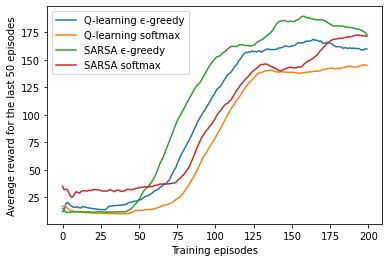

In [ ]:
# Plot the average reward for the last 50 episodes vs. number of training episodes
import matplotlib.pyplot as plt
plt.plot(q_egreedy_reward_avg50_list, label='Q-learning ϵ-greedy')
plt.plot(q_softmax_reward_avg50_list, label='Q-learning softmax')
plt.plot(sarsa_egreedy_reward_avg50_list, label='SARSA ϵ-greedy')
plt.plot(sarsa_softmax_reward_avg50_list, label='SARSA softmax')
plt.legend()
plt.xlabel('Training episodes')
plt.ylabel('Average reward for the last 50 episodes')
plt.show()